In [198]:
# PyTorch Library
import torch 
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to get the digit dataset
import torchvision.datasets as dsets
# Creating graphs
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import os
from PIL import Image
import torch.optim as optim

Use the following function to plot out the parameters of the Softmax function:

In [199]:
# The function to plot parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

Use the following function to visualize the data: 

In [200]:
# Plot the data
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

Load Datasets

In [201]:
train_dog_images = '/Users/joanmascastella/Desktop/CODE/backup/Cat_Dog_Classifier/Data/Train_Data/Dog'
train_cat_images = '/Users/joanmascastella/Desktop/CODE/backup/Cat_Dog_Classifier/Data/Train_Data/Cat'

validation_dog_images = '/Users/joanmascastella/Desktop/CODE/backup/Cat_Dog_Classifier/Data/Test_Data/Dog'
validation_cat_images = '/Users/joanmascastella/Desktop/CODE/backup/Cat_Dog_Classifier/Data/Test_Data/Cat'

Transform Images

- Ensure that images are all same size 
- Ensure that images are all grey scale
- Ensure that labels are applied

In [202]:
# Image transformations: resize to 128x128, convert to grayscale and transform to tensor
image_transforms = transforms.Compose([
    transforms.Grayscale(),        # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing grayscale images
])

Load images from folder and assign labels to them

In [203]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):  # Check for valid image files
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path)
                img = image_transforms(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipping non-image file: {filename}")
    return images, labels

Loading Images and assigning labels

In [204]:
#Train dataset
train_dog_tensors, train_dog_lables = load_images_from_folder(train_dog_images, 1)
train_cat_tensors, train_cat_lables = load_images_from_folder(train_cat_images, 0)

#Validation dataset
validation_dog_tensors, validation_dog_lables = load_images_from_folder(validation_dog_images, 1)
validation_cat_tensors, validation_cat_lables = load_images_from_folder(validation_cat_images, 0)

Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store


Combine all images and lables

In [205]:
train_images = train_dog_tensors + train_cat_tensors
train_labels = train_dog_lables + train_cat_lables

val_images = validation_dog_tensors + validation_cat_tensors
val_labels = validation_dog_lables + validation_cat_lables

Converting Lists to tensors

In [206]:
# Stack the image tensors
train_image_tensor = torch.stack(train_images) 
train_labels_tensor = torch.tensor(train_labels)  

validation_image_tensor = torch.stack(val_images)
validation_label_tensor = torch.tensor(val_labels)

Building a Softmax Classifier

In [207]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))  # Hidden layer with ReLU activation
        x = self.fc2(x)  # Output layer
        return x

In [208]:
# Parameters
input_size = 128 * 128  # Flattened image size
output_size = 2  # Binary classification: dog (1) and cat (0)

In [209]:
# Instantiate the model
model = SimpleNN(input_size=input_size, hidden_size=128, output_size=output_size)


In [210]:
train_image_tensor = train_image_tensor.view(train_image_tensor.size(0), -1)  # (30, 1, 128, 128) -> (30, 16384

In [211]:
output = model(train_image_tensor)
print(output.shape)  

torch.Size([30, 2])


Loss Function and Optimization

In [212]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_image_tensor, train_labels_tensor, validation_image_tensor, validation_label_tensor are already defined
# Create DataLoader objects for training and validation datasets
train_dataset = TensorDataset(train_image_tensor, train_labels_tensor)
validation_dataset = TensorDataset(validation_image_tensor, validation_label_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size of 32
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Number of times we train our model using the training data
n_epochs = 100
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
# Size of the validation data
N_test = len(validation_dataset)

# Function to train the model based on number of epochs
def train_model(n_epochs):
    # Loop over the number of epochs
    for epoch in range(n_epochs):
        # Set the model to training mode
        model.train()
        
        for x_batch, y_batch in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates
            optimizer.zero_grad()
            # Flatten input and make prediction
            z = model(x_batch.view(-1, 128 * 128))  # Flatten the input images
            # Calculate the loss between the model's predictions and the actual labels
            loss = criterion(z, y_batch)
            # Perform backpropagation to compute gradients
            loss.backward()
            # Update model weights
            optimizer.step()

        # Validation phase (we do not train here)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for x_val, y_val in validation_loader:
                # Flatten validation images and make predictions
                z_val = model(x_val.view(-1, 128 * 128))
                # Get predicted class (the one with the highest score)
                _, yhat = torch.max(z_val.data, 1)
                # Count correct predictions
                correct += (yhat == y_val).sum().item()
                total += y_val.size(0)

        # Calculate validation accuracy
        accuracy = correct / total

        # Append the loss and accuracy for each epoch
        loss_list.append(loss.item())  # .item() extracts the scalar value from the tensor
        accuracy_list.append(accuracy)

        # Print the loss and accuracy for the current epoch
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Instantiate the model (input size = 128*128 = 16384, output size = 2)
input_size = 128 * 128
output_size = 2
model = SoftMax(input_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # SGD optimizer

# Call the train_model function
train_model(n_epochs)

Epoch [1/100], Loss: 0.6978, Accuracy: 0.5333
Epoch [2/100], Loss: 0.6465, Accuracy: 0.5333
Epoch [3/100], Loss: 0.6026, Accuracy: 0.5333
Epoch [4/100], Loss: 0.5646, Accuracy: 0.5333
Epoch [5/100], Loss: 0.5315, Accuracy: 0.5333
Epoch [6/100], Loss: 0.5024, Accuracy: 0.5333
Epoch [7/100], Loss: 0.4766, Accuracy: 0.5000
Epoch [8/100], Loss: 0.4536, Accuracy: 0.5333
Epoch [9/100], Loss: 0.4330, Accuracy: 0.5333
Epoch [10/100], Loss: 0.4144, Accuracy: 0.5667
Epoch [11/100], Loss: 0.3974, Accuracy: 0.5000
Epoch [12/100], Loss: 0.3819, Accuracy: 0.4667
Epoch [13/100], Loss: 0.3676, Accuracy: 0.5000
Epoch [14/100], Loss: 0.3544, Accuracy: 0.5000
Epoch [15/100], Loss: 0.3422, Accuracy: 0.5333
Epoch [16/100], Loss: 0.3308, Accuracy: 0.5000
Epoch [17/100], Loss: 0.3202, Accuracy: 0.5000
Epoch [18/100], Loss: 0.3103, Accuracy: 0.5000
Epoch [19/100], Loss: 0.3010, Accuracy: 0.5000
Epoch [20/100], Loss: 0.2923, Accuracy: 0.5000
Epoch [21/100], Loss: 0.2840, Accuracy: 0.4667
Epoch [22/100], Loss: 

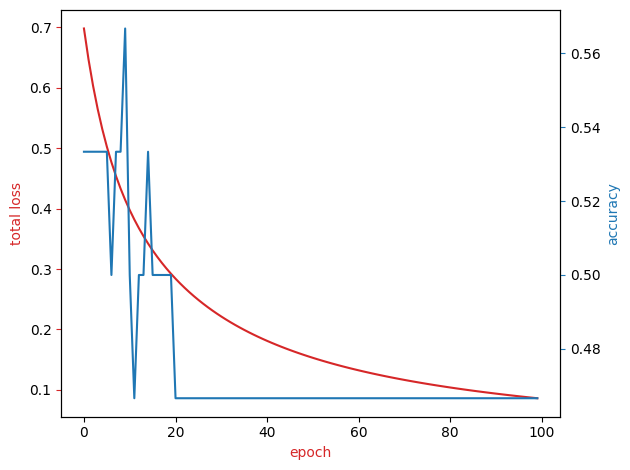

In [213]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()